In [1]:
# Imports of the packages needed for the implementation 
import mne as mne
from mne.preprocessing import ICA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from pylab import *
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Reading the training data from the folders 
S001 = "final-concatenation/S001/Training data/S001-final-concat.csv"
S002 = "final-concatenation/S002/Training data/S002-final-concat.csv"
#S003 = "final-concatenation/S003/Training data/S003-final-concat.csv"
#S004 = "final-concatenation/S004/Training data/S004-final-concat.csv"
#S005 = "final-concatenation/S005/Training data/S005-final-concat.csv"
#S006 = "final-concatenation/S006/Training data/S006-final-concat.csv"
#S007 = "final-concatenation/S007/Training data/S007-final-concat.csv"
#S008 = "final-concatenation/S008/Training data/S008-final-concat.csv"
#S009 = "final-concatenation/S009/Training data/S009-final-concat.csv"
#S010 = "final-concatenation/S010/Training data/S010-final-concat.csv"

# Form a list of files for the subjects training data
file_list = [S001, S002]
# , S003, S004, S005, S006, S007, S008, S009, S010

In [3]:
#This definition reads a csv file by opening it and reading using a csv reader from panda
# It drops the channels that are not going to be used for implementation, we want to focus on the channel 
# that helps with person identification. It then transposes the data so it creates an array list of the 
# each of the subjects data, we then identified the channel name that will be used and create information
# of the eeg data. we then create a raw array using an mne tool which is used for the analyses of EEG data
# It then filters the dataset and creates epochs and time points which will be fed into the classiifcation method 
# or will be used to extract features and returns the array of the epochs.abs

def read_data(file):
    Open_file = open(file)
    Read_file = pd.read_csv(Open_file)
    Read_file.drop(['# AF3', 'F3','FC5', 'T7','P7', 'O1','P8', 'T8', 'FC6', 'F4', 'F7','F8', 'AF4'], axis=1, inplace=True)
    file_transpose = Read_file.transpose()
    ch_names = ['O2']
    info = mne.create_info(ch_names = ch_names, ch_types=['eeg'] * len(ch_names), sfreq=250)
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(file_transpose, info)
    raw.pick_channels(['O2'])
    raw_filt = raw.copy().filter(l_freq=0.5, h_freq=59, picks='eeg')
    epochs = mne.make_fixed_length_epochs(raw_filt, duration=5,preload=True).pick_types(eeg=True)
    array  = epochs.get_data()
    return  array

In [4]:
# Using  the definition read_data to read through the file list of the training data
train_data = [read_data(i) for i in file_list]

Creating RawArray with float64 data, n_channels=1, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   552.956 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 1651 samples (6.604 sec)

Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 110 events and 1250 original time points ...
0 bad epochs dropped
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs

In [5]:
#Shape of the first training data 
train_data[0].shape, train_data[1].shape
len(train_data)

2

In [6]:
# Creating labels for thetraining data
data_labels0 = [len(i)*[0] for i in train_data[0]]
data_labels1 = [len(i)*[1] for i in train_data[1]]
#data_labels2 = [len(i)*[2] for i in train_data[2]]
#data_labels3 = [len(i)*[3] for i in train_data[3]]
#data_labels4 = [len(i)*[4] for i in train_data[4]]
#data_labels5 = [len(i)*[5] for i in train_data[5]]
#data_labels6 = [len(i)*[6] for i in train_data[6]]
#data_labels7 = [len(i)*[7] for i in train_data[7]]
#data_labels8 = [len(i)*[8] for i in train_data[8]]
#data_labels9 = [len(i)*[9] for i in train_data[9]]

# Concatenating the list of labels
train_data_labels = np.concatenate((data_labels0, data_labels1), axis=0)
#, data_labels2, data_labels3, data_labels4, data_labels5, data_labels6, data_labels7, data_labels8, data_labels9
len(train_data_labels)

220

In [7]:
# Creating a group list fo the cross validation 
group = [[i] * len(j) for i,j in enumerate(train_data)]
len(group)

2

In [8]:
# Converting the data, labels and group into arrays so we can feed it into the model
train_data_array = np.vstack(train_data)
train_data_labels_array = np.hstack(train_data_labels)
group_array = np.hstack(group)

In [9]:
train_data_array.shape, train_data_labels_array.shape, group_array.shape

((220, 1, 1250), (220,), (220,))

In [10]:
# moving the axis of time point and channel so it can be fed into the model
train_data_array = np.moveaxis(train_data_array, 1, 2)
train_data_array.shape

(220, 1250, 1)

In [11]:
# importing packages for he deep learning model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.base import TransformerMixin,BaseEstimator
import tensorflow
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input,Dense,concatenate,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow import keras

2022-09-30 04:30:35.206168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 04:30:35.381978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 04:30:35.382001: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-30 04:30:35.416173: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 04:30:36.312545: W tensorflow/stream_executor/pla

In [12]:
# assign the group fold variable 
gkf = GroupKFold(n_splits=2)

# considering that the training data is a 3 dimensional array, this class will accept 
# a 3d array and standardise it. BaseExtimator and TransformerMixin allows input thats passes
# the init definitions.  
class StandardScaler3D(BaseEstimator,TransformerMixin):
    # this init just calls the standard scaler function
    def __init__(self):
        self.scaler = StandardScaler()

    # fits the input and applies the standard scaler mathematical function
    # This fit defintion accepts one input which is x and reshapes it to two dimension
    # but at same time by figuring out what the third dimension does (-1) by lookig at the length of the array     
    def fit(self,x):
        self.scaler.fit(x.reshape(-1, x.shape[2]))
        return self

    # transform the the scaled input to fit the length of the input given 
    # it accepts one input which is x and reshapes it to two dimension
    # but at same time by figuring out what the third dimension does (-1) by lookig at the length of the array
    # and reshapes it data to fit the length of the input
    def transform(self,x):
        return self.scaler.transform(x.reshape( -1,x.shape[2])).reshape(x.shape)

In [13]:
# this is where the cross validation of splitting the training and labelling data using Group K fold 
# after spliting the data it then scales the data using the standardScaler 3D class that was defined previously
accuracy = []
for train_index, val_index in gkf.split(train_data_array, train_data_labels_array, groups=group_array):
    training , train_labels  = train_data_array[train_index], train_data_labels_array[train_index]
    validation, val_labels= train_data_array[val_index], train_data_labels_array[val_index]
    scaler = StandardScaler3D()
    train_features = scaler.fit_transform(training)
    val_features = scaler.transform(validation)

In [14]:
# shape of training features with a split of 50:50
training.shape

(110, 1250, 1)

In [15]:
# defining a block of CNN layers for feature extraction 
def block(input):
  conv1 = Conv1D(32, 3, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 3, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 3, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1, conv2, conv3],axis=2)
  return x

In [16]:
# applying the input which consists of timepoints and the channel to the block twice
input = Input(shape=(1250,1))
block1 = block(input)
block2=block(block1)
block2.shape

2022-09-30 04:30:37.752606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-30 04:30:37.752642: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-30 04:30:37.752659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-cdcd7b7a-2caf-40ce-9cca-562e2f317a32): /proc/driver/nvidia/version does not exist
2022-09-30 04:30:37.752877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([None, 313, 96])

In [17]:
# Applying the gru layers for the classification 
gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block2)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)

# the fully conneted layer using the Dense and an activation function of softmax
predictions = Dense(1, activation='softmax',)(gru_out4)

In [18]:
gru_out4.shape

TensorShape([None, 32])

In [19]:
# takes in the input and the prediction into the model for training 
model = Model(inputs=input, outputs=predictions)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [20]:
#fitting the model  
history = model.fit(training,train_labels,epochs=10,batch_size=128,validation_data=(validation,val_labels))

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.6931 - accuracy: 1.0000 - val_loss: 0.7149 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6719 - accuracy: 1.0000 - val_loss: 0.7420 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6466 - accuracy: 1.0000 - val_loss: 0.7767 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6161 - accuracy: 1.0000 - val_loss: 0.8212 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.5796 - accuracy: 1.0000 - val_loss: 0.8789 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.5366 - accuracy: 1.0000 - val_loss: 0.9544 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.4862 - accuracy: 1.0000 - val_loss: 1.0538 - val_accuracy: 0.0000e+00
Epoch 8/10


In [21]:
# getting the accuracy and loss of the model 
model.evaluate(validation, val_labels)

4/4 [==============================] - 1s 330ms/step - loss: 1.5967 - accuracy: 0.0000e+00


[1.5966551303863525, 0.0]

In [22]:
# getting the values for training and validation loss and function 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

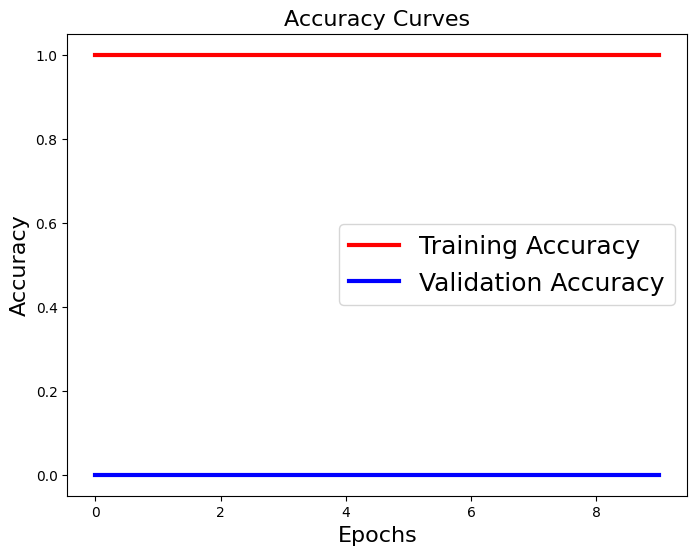

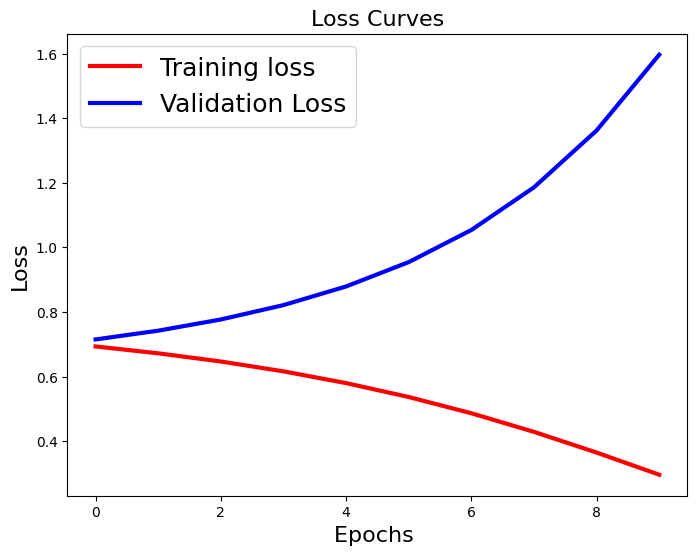

In [23]:
# accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.title('Accuracy Curves',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cdcd7b7a-2caf-40ce-9cca-562e2f317a32' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>